# Loading Modules

In [1]:
from display import Display, minmax, place_object
from main import init
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what import WhatShift, WhatBackground, WhatNet, test, MNIST
from spatial_transformer import SpatialTransNet
from where import RetinaFill, WhereShift, RetinaBackground, RetinaMask

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [2]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with the what noise parameters

- 28x28 pixel with shift and noise

In [3]:
transform=transforms.Compose([
                               WhatShift(args),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [4]:
data, label = next(iter(train_loader))

In [5]:
data.shape

torch.Size([100, 1, 28, 28])

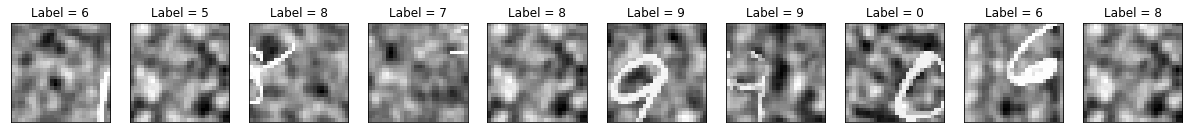

In [6]:
N_plot = 10
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
    ax.set_title("Label = %d"%(label[i_ax].item()))
    ax.set_xticks([])
    ax.set_yticks([])
#fig.savefig('../figures/noisy_no_shift_28x28_data.png')

# Spatial Transformer Network

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpatialTransNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = args.lr)
loss_func = nn.CrossEntropyLoss()


def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device, dtype=torch.float), target.to(device)
            output = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [8]:
for ofst in range(15+1):

    args.what_offset_std = ofst
    print("Training on offset_std = %s" %(args.what_offset_std))
    transform=transforms.Compose([
                                   WhatShift(args),
                                   WhatBackground(contrast = args.contrast,
                                                  noise=args.noise, 
                                                  sf_0=args.sf_0, 
                                                  B_sf=args.B_sf),
                                   transforms.ToTensor(),
                                   #transforms.Normalize((args.mean,), (args.std,))
                               ])

    train_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=True,
                            download=True,
                            transform=transform,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)


    test_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=False,
                            download=True,
                            transform=transform,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)
    
    args.epochs = 5
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        test(test_loader)

Training on offset_std = 0
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 2.308702
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 0.899114
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 0.360270
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 0.312816
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 0.412307
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 0.266019

Test set: Average loss: 0.0026, Accuracy: 9123/10000 (91%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 0.163282
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 0.244616
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.374861
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 0.131853
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 0.087714
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 0.208324

Test set: Average loss: 0.0016, Accuracy: 9477/10000 (95%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 0.133819
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.098765
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.041517
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.353563
Train Epoch: 3/5 [40000/60000 (67%

Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.219700
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.189232
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.397000
Train Epoch: 3/5 [40000/60000 (67%)]	Loss: 0.250713
Train Epoch: 3/5 [50000/60000 (83%)]	Loss: 0.287045

Test set: Average loss: 0.0030, Accuracy: 9017/10000 (90%)

Train Epoch: 4/5 [0/60000 (0%)]	Loss: 0.215920
Train Epoch: 4/5 [10000/60000 (17%)]	Loss: 0.286832
Train Epoch: 4/5 [20000/60000 (33%)]	Loss: 0.236869
Train Epoch: 4/5 [30000/60000 (50%)]	Loss: 0.357540
Train Epoch: 4/5 [40000/60000 (67%)]	Loss: 0.260089
Train Epoch: 4/5 [50000/60000 (83%)]	Loss: 0.322810

Test set: Average loss: 0.0035, Accuracy: 8852/10000 (89%)

Train Epoch: 5/5 [0/60000 (0%)]	Loss: 0.506525
Train Epoch: 5/5 [10000/60000 (17%)]	Loss: 0.411689
Train Epoch: 5/5 [20000/60000 (33%)]	Loss: 0.230355
Train Epoch: 5/5 [30000/60000 (50%)]	Loss: 0.218121
Train Epoch: 5/5 [40000/60000 (67%)]	Loss: 0.204142
Train Epoch: 5/5 [50000/60000 (83%)]	Loss: 0.398307

Tes

Train Epoch: 5/5 [10000/60000 (17%)]	Loss: 0.718259
Train Epoch: 5/5 [20000/60000 (33%)]	Loss: 0.558921
Train Epoch: 5/5 [30000/60000 (50%)]	Loss: 0.849097
Train Epoch: 5/5 [40000/60000 (67%)]	Loss: 0.737180
Train Epoch: 5/5 [50000/60000 (83%)]	Loss: 0.784413

Test set: Average loss: 0.0077, Accuracy: 7394/10000 (74%)

Training on offset_std = 9
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 0.866865
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 0.956922
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 0.841290
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 0.608383
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 0.965502
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 0.793127

Test set: Average loss: 0.0089, Accuracy: 6914/10000 (69%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 0.908586
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 0.710235
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.566091
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 0.880290
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 1.000216
Train Epoch: 2/5 [50000/60000

Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 1.223100
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 1.386592
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 1.337243
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 1.367824
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 1.152221

Test set: Average loss: 0.0137, Accuracy: 5051/10000 (51%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 1.332572
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 1.359937
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 1.213794
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 1.339092
Train Epoch: 3/5 [40000/60000 (67%)]	Loss: 1.252034
Train Epoch: 3/5 [50000/60000 (83%)]	Loss: 1.151754

Test set: Average loss: 0.0134, Accuracy: 5104/10000 (51%)

Train Epoch: 4/5 [0/60000 (0%)]	Loss: 1.397966
Train Epoch: 4/5 [10000/60000 (17%)]	Loss: 1.051006
Train Epoch: 4/5 [20000/60000 (33%)]	Loss: 1.122265
Train Epoch: 4/5 [30000/60000 (50%)]	Loss: 1.434717
Train Epoch: 4/5 [40000/60000 (67%)]	Loss: 1.322912
Train Epoch: 4/5 [50000/60000 (83%)]	Loss: 1.078951

Tes

# General accuracy

In [13]:
args.what_offset_std

15

In [14]:
test(test_loader)


Test set: Average loss: 0.0149, Accuracy: 4534/10000 (45%)



# Central accuracy

In [22]:
args.what_offset_std = 6
test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [16]:
test(test_loader)


Test set: Average loss: 0.0028, Accuracy: 9249/10000 (92%)



# Saving the model

In [17]:
PATH = "../models/stn_28x28_shift_dependant.pt"
torch.save(model, PATH)

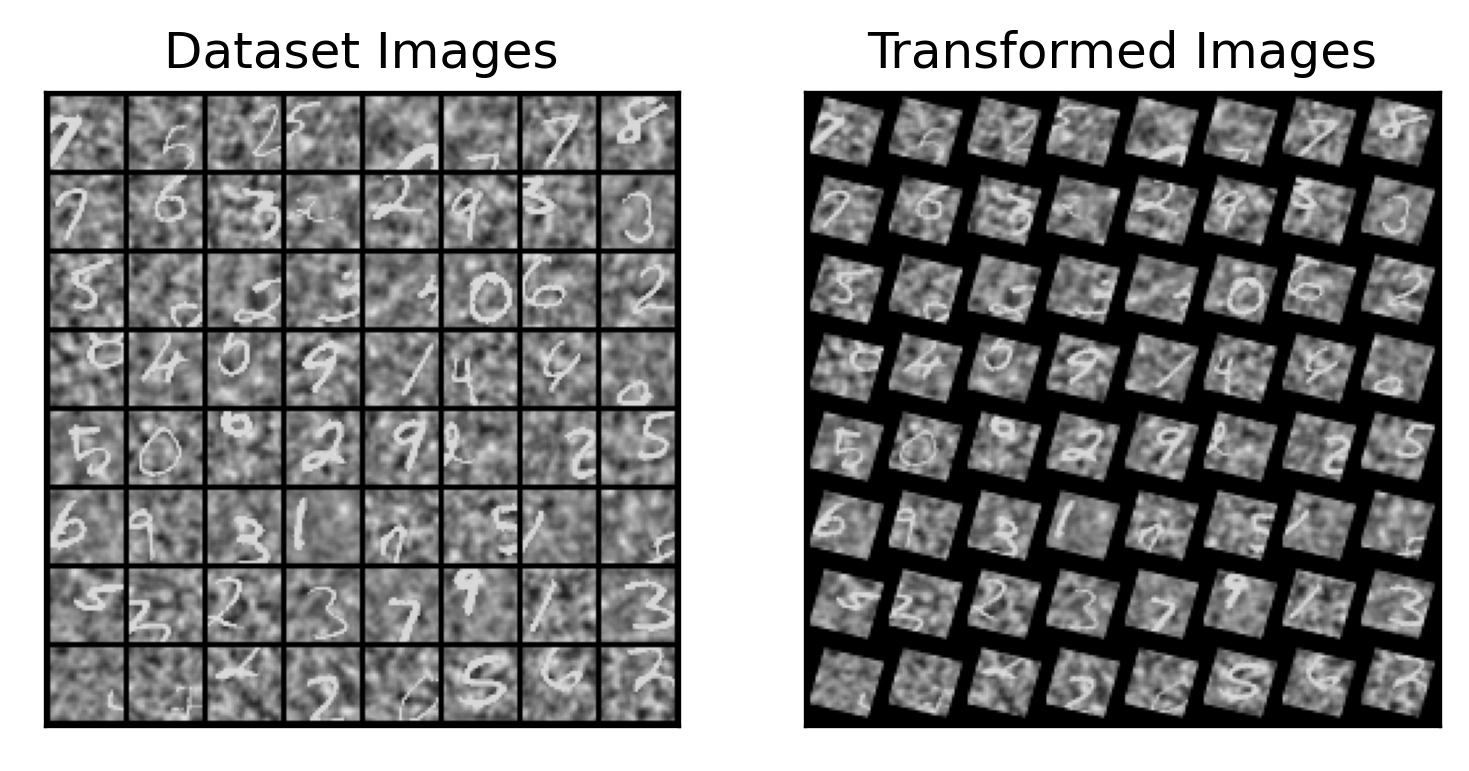

In [27]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:64, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        f.savefig('../figures/results_trained.png')
     
# Visualize the STN transformation on some input batch
visualize_stn()